## GetOldTweets 을 사용한 트위터 데이터 수집하기

안녕하세요, Fukushima project 참여중인 학생 김정욱 입니다.

공식 Twitter Api 사용하는 패키지인 tweepy가 premium 버전을 구매하여도 최대 30일밖에 data를 제공하지 않습니다.

그래서 bypass tool로 유명한 GetOldTweets3 (with python 3.x version)으로 테스트를 진행하고자 합니다.

아래는 참고 링크입니다.

- [Twitter premium APIs](https://developer.twitter.com/en/premium-apis)

- [GetOldTweets3 package description](https://pypi.org/project/GetOldTweets3/)

- https://github.com/Jefferson-Henrique/GetOldTweets-python

그러나 본 패키지를 사용함에 있어 우려 사항이 몇가지 발견되었습니다.

1. 몇몇 사용자들이 이 패키지로 트윗을 수집하였을 때 전량 수집이 되지 않는다고 응답했습니다.

2. 대량의 트윗을 본 패키지를 통해 수집할 경우, Twitter 측에서 ip 밴을 먹인다고 issue를 제기한 사용자가 있습니다.

https://github.com/Mottl/GetOldTweets3/issues/19

In [23]:
# GetOldTweet3 사용 준비

try:
    import GetOldTweets3 as got
except:
    !pip install GetOldTweets3
    import GetOldTweets3 as got


In [24]:
# 가져올 범위를 정의
# 예제 : 2011-01-01 ~ 2011-01-31

import datetime

days_range = []

start = datetime.datetime.strptime("2011-01-01", "%Y-%m-%d")
end = datetime.datetime.strptime("2011-02-01", "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_generated:
    days_range.append(date.strftime("%Y-%m-%d"))

print("=== 설정된 트윗 수집 기간은 {} 에서 {} 까지 입니다 ===".format(days_range[0], days_range[-1]))
print("=== 총 {}일 간의 데이터 수집 ===".format(len(days_range)))


=== 설정된 트윗 수집 기간은 2011-01-01 에서 2011-01-31 까지 입니다 ===
=== 총 31일 간의 데이터 수집 ===


In [25]:
# Beautifulsoup 사용

import requests
from bs4 import BeautifulSoup

def get_bs_obj(url):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'}
    result = requests.get(url, header)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    
    return bs_obj


In [87]:
# quary search
# option : id / permalink / username / to / text ... 

import time
from random import uniform
from tqdm import tqdm_notebook

# 트윗 수집 기준 정의
tweetCriteria = got.manager.TweetCriteria().setQuerySearch('방사선 OR 방사능 OR 원자력 OR 원전')\
                                           .setSince(days_range[0])\
                                           .setUntil(days_range[-1])\
                                           .setMaxTweets(-1)

# 수집 with GetOldTweet3

print("Collecting data start.. from {} to {}".format(days_range[0], days_range[-1]))
start_time = time.time()
tweet = got.manager.TweetManager.getTweets(tweetCriteria)
print("Collecting data end.. {0:0.2f} Minutes".format((time.time() - start_time)/60))
print("=== Total # of tweets is {} ===".format(len(tweet)))

# initialize
tweet_list = []

for index in tqdm_notebook(tweet):
    
    # 메타데이터 목록 
    username = index.username
    link = index.permalink 
    content = index.text
    tweet_date = index.date.strftime("%Y-%m-%d")
    tweet_time = index.date.strftime("%H:%M:%S")
    retweets = index.retweets
    favorites = index.favorites
    
    # === 개인 정보 수집 시작 ===
    try:
        personal_link = 'https://twitter.com/' + username
        bs_obj = get_bs_obj(personal_link)
        uls = bs_obj.find("ul", {"class": "ProfileNav-list"}).find_all("li")
        div = bs_obj.find("div", {"class": "ProfileHeaderCard-joinDate"}).find_all("span")[1]["title"]


        # 가입일, 전체 트윗 수, 팔로잉 수, 팔로워 수
        joined_date = div.split('-')[1].strip()
        num_tweets = uls[0].find("span", {"class": "ProfileNav-value"}).text.strip()
        num_following = uls[1].find("span", {"class": "ProfileNav-value"}).text.strip()
        num_follower = uls[2].find("span", {"class": "ProfileNav-value"}).text.strip()
    
    except AttributeError:
        print("=== Attribute error occurs at {} ===".format(link))
        print("link : {}".format(personal_link))
        pass
     
    # 결과 합치기
    info_list = [tweet_date, tweet_time, username, content, link, retweets, favorites, 
                 joined_date, num_tweets, num_following, num_follower]
    tweet_list.append(info_list)
    
    # 해치지 않을께요 밴 먹이지 마세요 ㅠㅠ 
    time.sleep(uniform(1,3))


=== Total # of tweets is 2820 ===


=== Attribute error occurs at https://twitter.com/kyh805/status/31734869851639809 ===
link : https://twitter.com/kyh805
=== Attribute error occurs at https://twitter.com/pboo13579/status/27672306507587584 ===
link : https://twitter.com/pboo13579
=== Attribute error occurs at https://twitter.com/kieonhan/status/26889103572209664 ===
link : https://twitter.com/kieonhan
=== Attribute error occurs at https://twitter.com/kannas01/status/22086717917888512 ===
link : https://twitter.com/kannas01


In [88]:
# make csv file

import pandas as pd

twitter_df = pd.DataFrame(tweet_list, 
                          columns = ["date", "time", "user_name", "text", "link", "retweet_counts", "favorite_counts",
                                    "user_created", "user_tweets", "user_followings", "user_followers"])
twitter_df.to_csv("twitter_data_{}_to_{}.csv".format(days_range[0], days_range[-1]), index=False)
print("=== Total # of tweets is {} ===".format(len(tweet_list)))

=== Total # of tweets is 2820 ===


In [89]:
# 파일 확인하기

df_tweet = pd.read_csv('twitter_data_{}_to_{}.csv'.format(days_range[0], days_range[-1]))
df_tweet.head(5)

,date,time,user_name,text,link,retweet_counts,favorite_counts,user_created,user_tweets,user_followings,user_followers
0,2011-01-30,23:59:41,hebarakiya,RT @patriamea: '반값 아파트'나 '반값 등록금' 공약은 지키지 않은 채...,https://twitter.com/hebarakiya/status/31864158...,0,0,2010년 8월 21일,374,71,30
1,2011-01-30,23:59:26,girisann,RT @sweety_hana: 촉구한다!RT@patriamea: '반값 아파트'나 ...,https://twitter.com/girisann/status/3186409203...,0,0,2010년 9월 11일,831,"1,644","1,100"
2,2011-01-30,23:58:30,ntiskang,RT @Talksori: RT @redsradio: UAE에 공사비 22조 가운데 ...,https://twitter.com/ntiskang/status/3186385732...,1,0,2009년 9월 30일,"19,457","3,489","7,863"
3,2011-01-30,23:58:29,kingkkachil,"@jwp615 야당 진짜 정신 차려야 합니다.. 원전 수주 내막, 구제역, 대북문제...",https://twitter.com/kingkkachil/status/3186385...,0,0,2010년 7월 15일,"12,335","3,477","3,387"
4,2011-01-30,23:58:04,fobi0446,RT @sutra40: 시사메거진 2580에서 UAE 원전 수주 이면을 공개한 후 ...,https://twitter.com/fobi0446/status/3186374738...,0,0,2010년 11월 23일,"1,701","4,564","3,711"


In [45]:
# 예외 발생한 id 확인 
# 팔로워 수와 팔로잉 수에서 attribute error 발생시킨 경우

for item in range(len(df_tweet)):
    if df_tweet["user_name"][item] == "kieonhan":
        print(df_tweet.iloc[item])

date                                                      2011-01-17
time                                                        06:30:36
user_name                                                   kieonhan
text               구제역 : 구제역 간단히 근본적으로 해결해야 한다 자연은 말한다 인간이 오염시켜 많...
link               https://twitter.com/kieonhan/status/2688910357...
retweet_counts                                                     0
favorite_counts                                                    0
user_created                                           2010년 11월 26일
user_tweets                                                      249
user_followings                                                 더 보기
user_followers                                                  더 보기
Name: 426, dtype: object


In [90]:
def get_keywords(dataframe):
    keywords = []
    text = dataframe["text"].lower()
    if "방사선" in text:
        keywords.append("방사선")
    if "방사능" in text:
        keywords.append("방사능")
    if "원자력" in text:
        keywords.append("원자력")
    if "원전" in text:
        keywords.append("원전")
    return ",".join(keywords)

df_tweet["keyword"] = df_tweet.apply(get_keywords,axis=1)

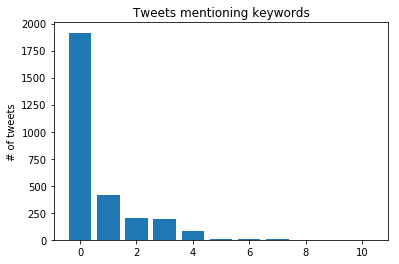

원전            1915
원자력            412
방사능            204
방사선            191
원자력,원전          82
방사능,원전           5
방사능,원자력          4
방사선,원자력,원전       3
                 2
방사선,원자력          1
방사선,방사능          1
Name: keyword, dtype: int64


In [91]:
import matplotlib.pyplot as plt
import numpy as np

counts = df_tweet["keyword"].value_counts()
plt.bar(range(len(counts)), counts)
plt.title("Tweets mentioning keywords")
plt.ylabel("# of tweets")
plt.show()
print(counts)

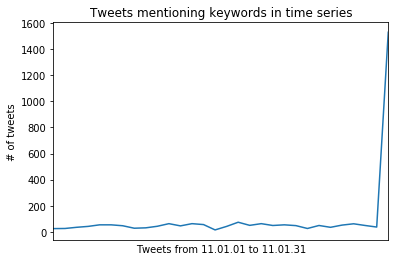

In [92]:
counts = df_tweet["date"].value_counts().sort_index()

plt.title("Tweets mentioning keywords in time series")
plt.ylabel("# of tweets")
plt.xlabel("Tweets from 11.01.01 to 11.01.31")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
counts.plot()


In [53]:
# 연구실 데이터 불러오기

df = pd.read_csv("2011_01_01to2011_01_31.txt", delimiter='\t',encoding='utf-8', header = None)
df.columns = ['id', 'link', 'date', 'text', 'ans', 'retweet', 'favorite']
df.head(5)

,id,link,date,text,ans,retweet,favorite
0,@bluebuzzkr,https://twitter.com/bluebuzzkr/status/31853054...,오후 3:15 - 2011년 1월 30일,"작년에 큰 뉴스거리였던 UAE의 원자력발전소 건설 수주(약 22조원), 이 중에서 ...",답글하기,리트윗 1,관심글 담기
1,@RT_HERO,https://twitter.com/RT_HERO/status/31840300582...,오후 2:24 - 2011년 1월 30일,@choimae 안녕하세요. 저는 강남세브란스 방사선종양학과에서 암치료를 담당하는 ...,답글하기,리트윗,관심글 담기
2,@kbsnewstweet,https://twitter.com/kbsnewstweet/status/318388...,오후 2:19 - 2011년 1월 30일,"엘바라데이, 시위현장 첫 참석…“즉각퇴진” 촉구 http://j.mp/iaHHfC ...",답글하기,리트윗 1,관심글 담기
3,@Miku_Verse_kbot,https://twitter.com/Miku_Verse_kbot/status/318...,오후 12:00 - 2011년 1월 30일,당신의 마음을 새빨갛게물들이는...사랑과방사능과■■■을마구뿌리는마법소녀 래디컬페인트...,답글하기,리트윗,관심글 담기
4,@semaing,https://twitter.com/semaing/status/31769265094...,오전 9:42 - 2011년 1월 30일,RT @hangulo 한전 UAE 원자력 본부장은.. 불행히도 계약 내용을 제대로 ...,답글하기,리트윗 3,관심글 담기 1


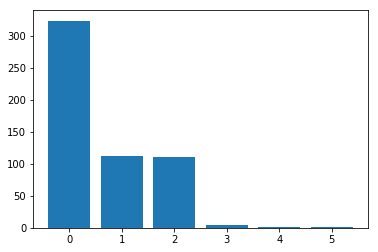

원자력            324
방사선            113
방사능            111
방사선,원자력          4
방사선,방사능,원자력      2
방사능,원자력          2
Name: keyword, dtype: int64


In [52]:
df["keyword"] = df.apply(get_keywords,axis=1)

counts = df["keyword"].value_counts()
plt.bar(range(len(counts)), counts)
plt.show()
print(counts)